this notebook will be used to show the performance of the first attempt at learning reward.

first load the trained reward network anbd setup methods.

In [1]:
from baselines.common.vec_env import VecFrameStack
from comp300.LearningModel.AgentClasses import *
from baselines.common.cmd_util import make_vec_env
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from os import listdir
from os.path import isfile, join
import re

/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/patrick/PycharmProjects/comp300/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/patrick/PycharmP

In [2]:



#setup the env
model_path = "/home/patrick/models/MsPacmanNoFrameskip-v4-demonstrator"
env_id = 'MsPacmanNoFrameskip-v4'
env_type = 'atari'

env = make_vec_env(env_id, env_type, 1, 0,
                   wrapper_kwargs={
                       'clip_rewards': False,
                       'episode_life': False,
                   })
env = VecFrameStack(env, 4)

#load the reward network
trainedNetwork = RewardNetwork("", env=env, env_type=env_type)
trainedNetwork.load_state_dict(torch.load("/home/patrick/models/mspacman-reward/fullTest2.params"))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
agent = PPO2Agent(env, env_type, True)
trainedNetwork.to(device)

#run the agent in the env once and save the ground truth reward and observations
def GetDemoFromAgent(agent, network, env):
    trueReward = 0
    learnedReward = 0

    currentReward = 0
    currentObservation = env.reset()
    timeSteps = 0
    done = False

    #run the demo
    while True:
        trueReward += currentReward
        shapedObservation = torch.from_numpy(currentObservation).float().to(device)
        reward, abs_reward = network.predict_reward(shapedObservation)
        learnedReward += reward.tolist()

        action = agent.act(currentObservation,  currentReward, done)
        currentObservation, currentReward, done, info = env.step(action)
        shapedObservations = currentObservation
        timeSteps += 1

        if done:
            trueReward += currentReward
            reward, abs_reward = network.predict_reward(shapedObservation)
            learnedReward += reward.tolist()
            break
    print("{}, {}".format(trueReward, learnedReward))
    return trueReward, learnedReward

#a method to find all the models in a given dir that are just numbers
def Find_all_Models(model_dir):

    checkpoints = []
    filesandDirs = listdir(model_dir)
    allFiles = []
    for i in filesandDirs:
        if isfile(join(model_dir, i)):
            allFiles.append(i)

    for file in allFiles:
        if re.match('^[0-9]+$',file.title()):
            checkpoints.append(file.title())

    return checkpoints




Logging to /tmp/openai-2020-03-23-17-55-02-421856





Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use keras.layers.flatten instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


now load all models and run each to get demos to run the network on

In [3]:
trueRewards = []
learnedRewards = []

models = Find_all_Models(model_path)

for model in models:
    agent.load(model_path + "/" + model)
    trueReward, learnedReward = GetDemoFromAgent(agent, trainedNetwork, env)
    tf.keras.backend.clear_session()
    trueRewards.append(trueReward[0])
    learnedRewards.append(learnedReward)
    
maxTrue = max(trueRewards)
maxLearned = max(learnedRewards)
normalisedRewards = learnedRewards / (maxLearned / maxTrue)


[1670.], 21.775064401328564
[1520.], 23.26139945164323
[1620.], 16.0153828561306
[1570.], 47.117721531540155
[1890.], 15.19643047824502
[1710.], 58.42593840509653
[2580.], 48.58189073950052
[1500.], 22.31797257065773
[1230.], 20.91734129190445
[1720.], 32.84174715727568
[1090.], 1.9195680692791939
[2540.], 53.71244094148278
[1630.], 31.072570402175188
[430.], 13.037646032869816
[1780.], 52.43667808920145
[1910.], 53.965625025331974
[1580.], 16.39131949469447
[1550.], 40.68143967911601
[1240.], -0.2172967568039894
[1410.], 47.46194911748171
[1860.], 26.71219750866294
[1860.], 32.58637472614646
[1670.], 18.4880357272923
[480.], 3.3517245687544346
[1890.], 31.010309036821127
[2050.], 34.488207314163446
[1630.], 40.774534333497286
[1790.], 19.805217877030373
[1340.], 6.926789797842503
[1570.], 50.987991347908974
[1160.], 19.218161422759295
[1020.], -0.13196692615747452
[780.], 14.885811947286129
[2010.], 42.50755913555622
[1220.], 12.731301046907902
[870.], 9.494481459259987
[700.], 16.971

In [4]:
maxTrue = max(trueRewards)
minLearned = min(learnedRewards)
normalisedRewards = [x-minLearned for x in learnedRewards]
copyLearned = []
copyTrue = []
for i in range(len(normalisedRewards)):
    if normalisedRewards[i] > 500000:
        pass
    else:
        copyLearned.append(normalisedRewards[i])
        copyTrue.append(trueRewards[i])
maxLearned = max(copyLearned)
copyLearned = (copyLearned) / (maxLearned / maxTrue)

3130.0,107.05008362978697


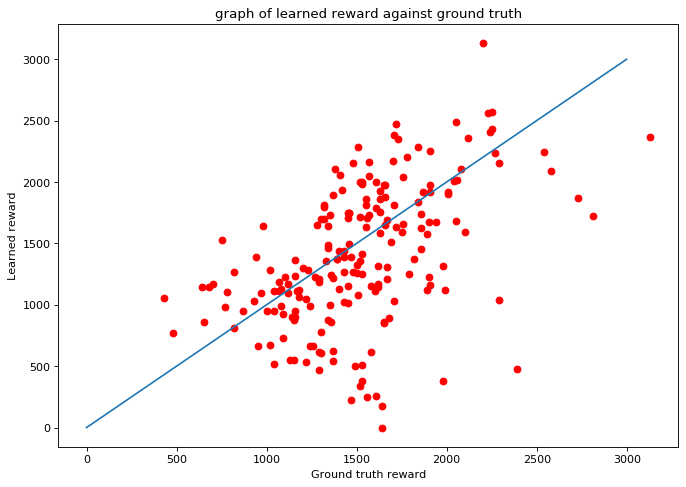

In [7]:
from matplotlib.pyplot import figure

print("{},{}".format(maxTrue, maxLearned))

figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(np.array(copyTrue), np.array(copyLearned), c='r')
plt.plot(np.arange(3000), np.arange(3000))
plt.ylabel("Learned reward")
plt.xlabel("Ground truth reward")
plt.title("graph of learned reward against ground truth")
plt.show()

In [8]:
minReward = [min(trueRewards)]
maxReward = [max(trueRewards)]
average = [sum(trueRewards) / len(trueRewards)]

from comp300.LearningModel.getAverageReward import *
agent.load("~/models/mspacman-reward-rl/mspacman_50M2_ppo2")
meanR, minR,maxR, std = getAvgReward(agent, env, 20)

minReward.append(minR)
maxReward.append(maxR)
average.append(meanR)


mins: [430.0, 730.0], maxs: [3130.0, 2740.0], means: [1513.35, 1396.5]


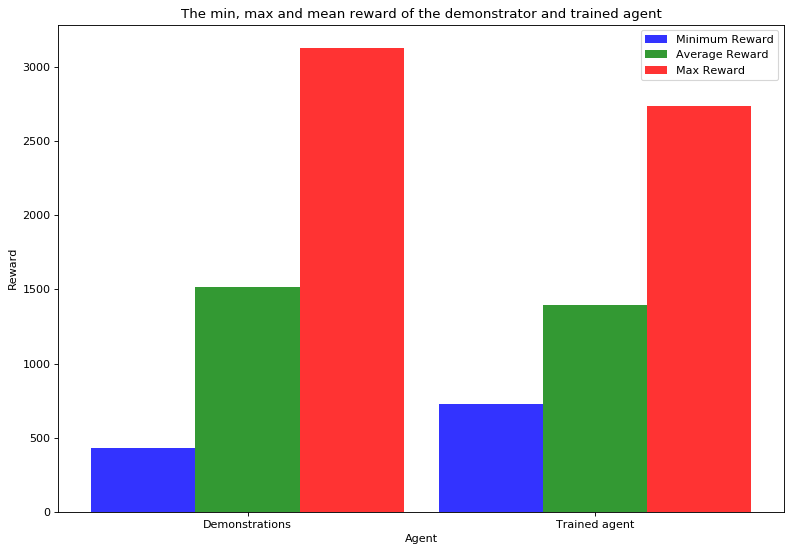

In [9]:
minReward[0] = min(trueRewards)
maxReward[0] = max(trueRewards)
average[0] = sum(trueRewards) /len(trueRewards)
print("mins: {}, maxs: {}, means: {}".format(minReward, maxReward, average))
# create plot
figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
#fig, ax = plt.subplots()
index = np.arange(2)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, minReward, bar_width,
alpha=opacity,
color='b',
label='Minimum Reward')

rects2 = plt.bar(index + bar_width, average, bar_width,
alpha=opacity,
color='g',
label='Average Reward')

rects3 = plt.bar(index + bar_width +bar_width, maxReward, bar_width,
alpha=opacity,
color='r',
label='Max Reward')

plt.xlabel('Agent')
plt.ylabel('Reward')
plt.title('The min, max and mean reward of the demonstrator and trained agent')
plt.xticks(index + bar_width, ('Demonstrations', 'Trained agent'))
plt.legend()

plt.tight_layout()
plt.show()

(<Figure size 720x504 with 1 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa62cc563c8>]],
       dtype=object))

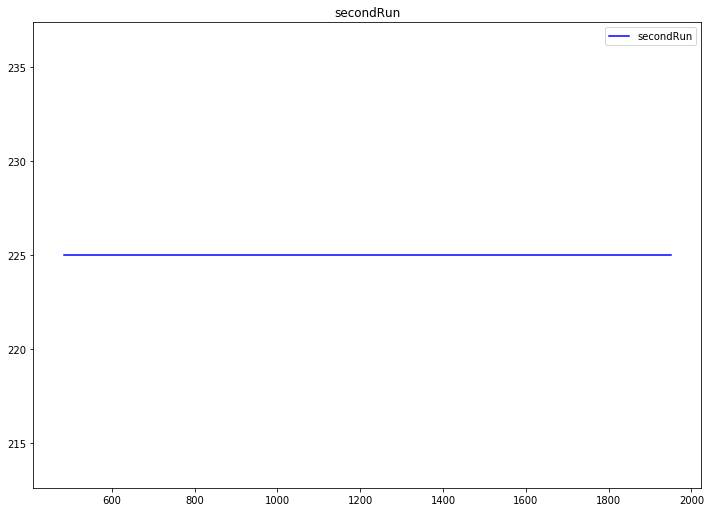

In [14]:
from baselines.common import plot_util as pu
results = pu.load_results('~/logs/Agent/mspacman-reward-RL-secondRun')
pu.plot_results(results, figsize=(10, 7))